<a href="https://colab.research.google.com/github/norok2/BenchmarkTemplateIPY/blob/master/Benchmarking_Template_FlyingCircus.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Methods

## Requirements

In [1]:
!pip install --upgrade flyingcircus

     |████████████████████████████████| 215kB 9.3MB/s 
     |████████████████████████████████| 61kB 24.5MB/s 


## Helper Functions

In [0]:
import itertools
import random
import timeit

import numpy as np

import matplotlib as mpl
import matplotlib.pyplot as plt

import flyingcircus as fc

random.seed(0)


def plot_benchmarks(
        summaries,
        input_sizes,
        labels,
        panels=('Small', 'Medium', 'Large'),
        units='μs',
        err_alpha=0.1,
        zoom_fastest=None,
        legend_kws=(('loc', 'upper right'),),
        save_filepath='benchmarks.png',
        dry=True):
    num_panels = len(panels)
    subplot_shape = 1, num_panels
    fig, axs = plt.subplots(
        *subplot_shape, squeeze=False, figsize=(16, 4))
    if units.endswith('s') and len(units) == 2:
        units_factor = 10 ** (-fc.base.prefix_to_order(units[0]))
    else:
        units_factor = 1
    n = len(input_sizes)
    m = len(labels)
    for i, panel in enumerate(panels):
        ij = np.unravel_index(i, subplot_shape)
        plot_sizes = int(len(input_sizes) * ((i + 1) / num_panels))
        axs[ij].set_title(panel)
        axs[ij].set_xlabel('Input Sizes / #')
        axs[ij].set_ylabel('Timings / ' + units)
        for k, label in enumerate(labels):
            x = input_sizes[:plot_sizes]
            y = np.array([summaries[i][k]['mean'] for i in range(plot_sizes)]) * units_factor
            dy = np.array([summaries[i][k]['stdev'] for i in range(plot_sizes)]) * units_factor
            axs[ij].plot(x, y, label=label)
            axs[ij].fill_between(x, y - dy, y + dy, alpha=err_alpha)
            if legend_kws is None:
                axs[ij].legend()
        if zoom_fastest:
            y_max = units_factor * zoom_fastest * (
                np.min(np.array([summaries[plot_sizes - 1][k]['mean'] for k in range(m)])))
            axs[ij].set_ylim([0.0, y_max])
    if legend_kws is not None:
        handles, labels = axs[0, 0].get_legend_handles_labels()
        fig.legend(handles, labels, **dict(legend_kws))
    if save_filepath and not dry:
        fig.tight_layout()
        fig.savefig(save_filepath.replace(' ', '_'))


In [0]:
%load_ext Cython

## Definitions

In [4]:
%%cython -c-O3 -c-march=native -a
#cython: language_level=3, boundscheck=False, wraparound=False, initializedcheck=False, cdivision=True, infer_types=True
import numpy as np
import cython as cy
import functools

cimport cython as ccy
cimport numpy as cnp


cpdef f_cy(items):
    return [item * item for item in items]

In [0]:
import numba as nb
import functools


def f1(items):
    return [item * item for item in items]


def f2(items):
    return [item ** 2 for item in items]


def f3(items, dtype=None):
    if dtype is None:
        dtype = type(items[0])
    return [dtype(((item ** 2) ** 0.5) ** 2) for item in items]


f4 = functools.partial(f3, dtype=float)
f4.__name__ = 'f4'


f5 = functools.partial(f3, dtype=complex)
f5.__name__ = 'f5'


@nb.jit()
def f_nb(items):
    return [item * item for item in items]


funcs = f1, f2, f3, f4, f5, f_cy, f_nb


def gen_input(n):
    return [random.random() for _ in range(n)]


def equal_output(a, b):
    return a == b

## Quick Output Check

In [6]:
test_inputs = (
    tuple(range(10)),
    tuple(range(20)),
)

for func in funcs:
    print('Func:', func.__name__)
    for test_input in test_inputs:    
        print(func(test_input))
    print()

Func: f1
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361]

Func: f2
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361]

Func: f3
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324, 361]

Func: f4
[0.0, 1.0, 4.0, 9.0, 16.0, 25.0, 36.0, 49.0, 64.0, 81.0]
[0.0, 1.0, 4.0, 9.0, 16.0, 25.0, 36.0, 49.0, 64.0, 81.0, 100.0, 121.0, 144.0, 169.0, 196.0, 225.0, 256.0, 289.0, 324.0, 361.0]

Func: f5
[0j, (1+0j), (4+0j), (9+0j), (16+0j), (25+0j), (36+0j), (49+0j), (64+0j), (81+0j)]
[0j, (1+0j), (4+0j), (9+0j), (16+0j), (25+0j), (36+0j), (49+0j), (64+0j), (81+0j), (100+0j), (121+0j), (144+0j), (169+0j), (196+0j), (225+0j), (256+0j), (289+0j), (324+0j), (361+0j)]

Func: f_cy
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81]
[0, 1, 4, 9, 16, 25, 36, 49, 64, 81, 100, 121, 144, 169, 196, 225, 256, 289, 324

# Results

## Benchmarks

In [7]:
# : for linear (n) problems
# input_sizes = (5, 10, 50, 100, 500, 1000, 5000, 10000, 50000, 100000)
# input_sizes = tuple(10 * (i + 1) for i in range(24))  # lin-spaced
# input_sizes = tuple(2 ** (i + 1) for i in range(16))  # geom-spaced
# input_sizes = tuple(int(2 ** (2 + (3 * i) / 4)) for i in range(20))  # frac-pow-spaced

# : for quadratic (n²) problems
# input_sizes = (5, 10, 50, 100, 500, 1000, 5000)
# input_sizes = tuple(10 * (i + 1) for i in range(24))  # lin-spaced
# input_sizes = tuple(2 ** (i + 1) for i in range(12))  # geom-spaced
# input_sizes = tuple(int(2 ** (2 + (3 * i) / 4)) for i in range(15))  # frac-pow-spaced

input_sizes = tuple(int(2 ** (2 + (3 * i) / 4)) for i in range(10))
print('Input Sizes:\n', input_sizes, '\n')

summaries, labels, results = fc.base.multi_benchmark(
    funcs, gen_input=gen_input, equal_output=equal_output,
    input_sizes=input_sizes,
    time_prof_kws=dict(
        timeout=1.0, max_iter=2 ** 24, min_iter=4, batch_size=8,
        batch_val_func=min, batch_err_func=lambda x: min(fc.base.diff(x)),
        combine_val_func=None, combine_err_func=None,
        use_gc=False, quick=True, verbose=fc.VERB_LVL['none']))

Input Sizes:
 (4, 6, 11, 19, 32, 53, 90, 152, 256, 430) 

N = (4, 6, 11, 19, 32, 53, 90, 152, 256, 430)
 
:f1()    N=4       OK  (32.0 ± 38.7) ns           102k / 8
:f2()    N=4       OK  (187.0 ± 27.1) ns           94k / 8
:f3()    N=4       OK  (1.2030 ± 0.0883) μs        52k / 8
:f4()    N=4       OK  (1.242 ± 0.118) μs          46k / 8
:f5()    N=4       OK  (1.3490 ± 0.0961) μs        47k / 8
:f_cy()  N=4       OK  (1000 ± 10400) ps          142k / 8
:f_nb()  N=4       OK  (594 ± 674) ns              12k / 8
 
:f1()    N=6       OK  (38.0 ± 32.2) ns            98k / 8
:f2()    N=6       OK  (445.0 ± 73.3) ns           85k / 8
:f3()    N=6       OK  (1.003 ± 0.247) μs          40k / 8
:f4()    N=6       OK  (1.275 ± 0.162) μs          41k / 8
:f5()    N=6       OK  (2.207 ± 0.104) μs          38k / 8
:f_cy()  N=6       OK  (2.0 ± 12.3) ns            136k / 8
:f_nb()  N=6       OK  (2.61 ± 1.03) μs            10k / 8
 
:f1()    N=11      OK  (106.0 ± 58.7) ns           85k / 8
:f2()

## Plots

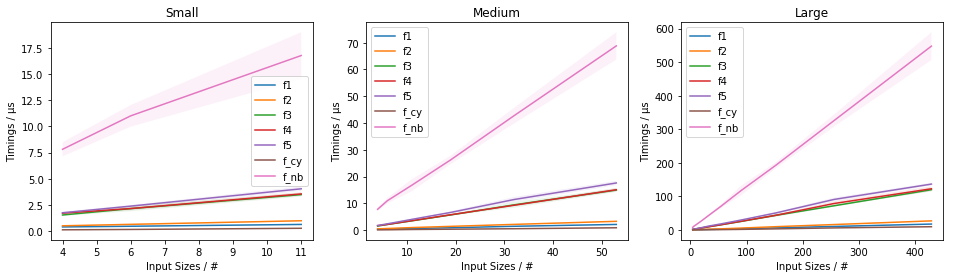

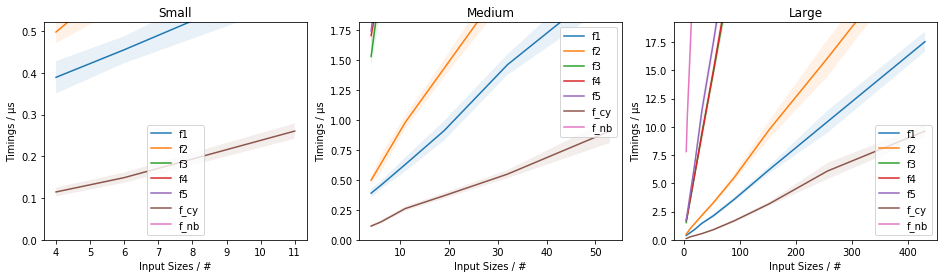

In [11]:
plot_benchmarks(summaries, input_sizes, labels, units='μs', legend_kws=None)
plot_benchmarks(summaries, input_sizes, labels, units='μs', zoom_fastest=2, legend_kws=None)